written by Nutchaya Phumekham, July 2022

## Determine the top used datasets by CRAB_UserHN and Workflow frequency. Also show their CpuTimeHr and  Size

Read the following for reference:   
- https://github.com/dmwm/CMSSpark/blob/master/src/python/CMSSpark/rucio_datasets_last_access_ts.py#L88
- https://github.com/dmwm/CMSSpark/blob/master/src/python/CMSSpark/rucio_datasets_last_access_ts.py#L36
- https://github.com/dmwm/CMSSpark/blob/master/src/python/CMSSpark/schemas.py#L168

In [1]:
from utils import (
    _to_dict,
    _donut,
    _pie,
    _line_graph,
    _other_fields,
    _exitcode_info
)
from datetime import datetime, date, timedelta
from pyspark.sql.functions import (
    col,
    lit,
    when,
    sum as _sum,
    count as _count,
    first,
    date_format,
    from_unixtime,
    to_date,
    countDistinct
)
import numpy as np
import pandas as pd
from pyspark.sql.types import (
    StructType,
    LongType,
    StringType,
    StructField,
    DoubleType,
    IntegerType,
)
import matplotlib.pyplot as plt

In [2]:
def _get_schema():
    return StructType(
        [
            StructField(
                "data",
                StructType(
                    [
                        StructField("RecordTime", LongType(), nullable=False),
                        StructField("InputData", StringType(), nullable=True),
                        StructField("Status", StringType(), nullable=True),
                        StructField("DESIRED_CMSDataset", StringType(), nullable=True),
                        StructField("CpuTimeHr", DoubleType(), nullable=True),
                        StructField("RequestCpus", LongType(), nullable=True),
                        StructField("GlobalJobId", StringType(), nullable=False),
                        StructField("CMS_SubmissionTool", StringType(), nullable=True),
                        StructField("CMS_TaskType", StringType(), nullable=True),
                        StructField("TaskType", StringType(), nullable=True),
                        StructField("CRAB_UserHN", StringType(), nullable=True),
                        StructField("USER", StringType(), nullable=True),
                        StructField("Workflow", StringType(), nullable=True),
                        StructField("CRAB_DataBlock", StringType(), nullable=True),
                        StructField("CMSPrimaryDataTier", StringType(), nullable=True)
                        
                    ]
                ),
            ),
        ]
    )

In [3]:
def get_candidate_files(start_date, end_date, spark, base):
    st_date = start_date - timedelta(days=3)
    ed_date = end_date + timedelta(days=3)
    days = (ed_date - st_date).days
    pre_candidate_files = [
        "{base}/{day}{{,.tmp}}".format(
            base=base, day=(st_date + timedelta(days=i)).strftime("%Y/%m/%d")
        )
        for i in range(0, days)
    ]
    sc = spark.sparkContext
    candidate_files = [
        f"{base}/{(st_date + timedelta(days=i)).strftime('%Y/%m/%d')}"
        for i in range(0, days)
    ]
    FileSystem = sc._gateway.jvm.org.apache.hadoop.fs.FileSystem
    URI = sc._gateway.jvm.java.net.URI
    Path = sc._gateway.jvm.org.apache.hadoop.fs.Path
    fs = FileSystem.get(URI("hdfs:///"), sc._jsc.hadoopConfiguration())
    candidate_files = [url for url in candidate_files if fs.globStatus(Path(url))]
    return candidate_files


In [4]:
_DEFAULT_HDFS_FOLDER = "/project/monitoring/archive/condor/raw/metric"
HDFS_DBS_FILES = '/project/awg/cms/CMS_DBS3_PROD_GLOBAL/current/FILES/part-m-00000'
HDFS_DBS_DATASETS = '/project/awg/cms/CMS_DBS3_PROD_GLOBAL/current/DATASETS/part-m-00000'

In [5]:
schema = _get_schema()
start_date = datetime(2022, 5, 1)
end_date = datetime(2022, 5, 8)

In [6]:
get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER)

['/project/monitoring/archive/condor/raw/metric/2022/04/28',
 '/project/monitoring/archive/condor/raw/metric/2022/04/29',
 '/project/monitoring/archive/condor/raw/metric/2022/04/30',
 '/project/monitoring/archive/condor/raw/metric/2022/05/01',
 '/project/monitoring/archive/condor/raw/metric/2022/05/02',
 '/project/monitoring/archive/condor/raw/metric/2022/05/03',
 '/project/monitoring/archive/condor/raw/metric/2022/05/04',
 '/project/monitoring/archive/condor/raw/metric/2022/05/05',
 '/project/monitoring/archive/condor/raw/metric/2022/05/06',
 '/project/monitoring/archive/condor/raw/metric/2022/05/07',
 '/project/monitoring/archive/condor/raw/metric/2022/05/08',
 '/project/monitoring/archive/condor/raw/metric/2022/05/09',
 '/project/monitoring/archive/condor/raw/metric/2022/05/10']

In [7]:
raw_df = (
        spark.read.option("basePath", _DEFAULT_HDFS_FOLDER)
        .json(
            get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER),
            schema=schema,
        ).select("data.*")
        .filter(
            f"""RecordTime >= {start_date.timestamp() * 1000}
          AND RecordTime < {end_date.timestamp() * 1000}
          """
        )
        .drop_duplicates(["GlobalJobId"])
    )

spark.conf.set("spark.sql.session.timeZone", "UTC")

### df1 - time range 05/01 - 05/08 (7days) 
show _sum(CpuTimeHr), _count(CRAB_UserHN), _count(Workflow) used by each dataset for this week

In [8]:
df1 = raw_df.select(col('DESIRED_CMSDataset'),\
                    col('CpuTimeHr'),\
                    col('CRAB_UserHN'),\
                    col('Workflow'))\
            .groupby(col('DESIRED_CMSDataset'))\
            .agg(_sum("CpuTimeHr").alias("sum_CpuTimeHr"),\
                countDistinct(col("CRAB_UserHN")).alias("distinct_CRAB_UserHN"),
                countDistinct(col("Workflow")).alias("distinct_Workflow"))\
            .orderBy(col('distinct_CRAB_UserHN').desc())

### df2 - find dataset size

In [9]:
# !git clone https://github.com/dmwm/CMSSpark.git

In [10]:
from CMSSpark.src.python.CMSSpark import schemas as cms_schemas
csvreader = spark.read.format('csv') \
        .option('nullValue', 'null') \
        .option('mode', 'FAILFAST')
dbs_files = csvreader.schema(cms_schemas.schema_files()) \
        .load(HDFS_DBS_FILES) \
        .withColumnRenamed('f_logical_file_name', 'f_name')
dbs_datasets = csvreader.schema(cms_schemas.schema_datasets()) \
        .load(HDFS_DBS_DATASETS) \
        .select(['d_dataset_id', 'd_dataset'])
df_dbs_f_d = dbs_files.join(dbs_datasets, dbs_files.f_dataset_id == dbs_datasets.d_dataset_id, how='left') \
        .withColumnRenamed('f_dataset_id', 'dataset_id') \
        .withColumnRenamed('d_dataset', 'dataset') \
        .select(['f_name', 'dataset', 'f_file_size'])

In [11]:
df2 = df_dbs_f_d.groupby(['dataset'])\
                                .agg(_sum(col('f_file_size')).alias('sum_file_size'))\
                                .orderBy(col('sum_file_size').desc())

### df3 - join df1 and df2 on dataset name

In [12]:
df3 = df1.join(df2, df1.DESIRED_CMSDataset == df2.dataset, how='left')\
        .select(['DESIRED_CMSDataset', 'distinct_CRAB_UserHN', 'distinct_Workflow', 'sum_file_size','sum_CpuTimeHr'])\
        .filter(col('DESIRED_CMSDataset').isNotNull())\
        .orderBy(col('distinct_Workflow').desc())

In [13]:
df3.printSchema()

root
 |-- DESIRED_CMSDataset: string (nullable = true)
 |-- distinct_CRAB_UserHN: long (nullable = false)
 |-- distinct_Workflow: long (nullable = false)
 |-- sum_file_size: double (nullable = true)
 |-- sum_CpuTimeHr: double (nullable = true)



### Plot graphs of df3 - time range 05/01 - 05/08 (7days) 

In [14]:
df3_pandas = df3.toPandas()

In [15]:
df3_pandas

,DESIRED_CMSDataset,distinct_CRAB_UserHN,distinct_Workflow,sum_file_size,sum_CpuTimeHr
0,/GenericTTbar/HC-CMSSW_9_2_6_91X_mcRun1_realis...,8,211,1.135249e+11,37300.481389
1,/Cosmics/Commissioning2021-PromptReco-v1/AOD,2,79,1.290279e+13,0.000000
2,/ParkingBPH1/Run2018D-05May2019promptD-v1/MINIAOD,8,69,1.280304e+14,0.000000
3,/ParkingBPH5/Run2018D-05May2019promptD-v1/MINIAOD,8,67,1.286476e+14,0.000000
4,/ParkingBPH2/Run2018D-05May2019promptD-v1/MINIAOD,8,67,1.287267e+14,0.021944
...,...,...,...,...,...
15684,/splitSUSY_M1400_1300_ctau300p0_TuneCP2_13TeV-...,0,1,4.892020e+09,0.724444
15685,/splitSUSY_M2000_1900_ctau0p1_TuneCP2_13TeV-py...,0,1,5.484184e+09,0.000000
15686,/ttPhiPS_M-100_2e_13TeV-madgraph/RunIIFall17Mi...,1,1,7.097513e+09,0.000000
15687,/ttPhiPS_M-40_2mu_13TeV-madgraph/RunIIAutumn18...,1,1,7.021434e+09,0.000000


In [154]:
def short_datasetname(lst: list):
    tmp = []
    for name in lst:
        if((len(name.split("/")[1])<15) & (len(name.split("/")[2])<15)):
            tmp.append("/"+"/".join([name.split("/")[i] for i in range(1,4)]))
        elif((len(name.split("/")[2])>15) & (len(name.split("/")[1])<15)):
            tmp.append("/"+name.split("/")[1]+"/"+name.split("/")[2][0:15]+".../"+name.split("/")[3])
        elif((len(name.split("/")[1])>15) & (len(name.split("/")[2])<15)):
            tmp.append("/"+name.split("/")[1][0:15]+".../"+name.split("/")[2]+"/"+name.split("/")[3])
        else:
            tmp.append("/"+".../".join([name.split("/")[i][0:15] for i in range(1,3)])+".../"+name.split("/")[3])
    return tmp

In [143]:
dataset_CRAB_UserHN = df3_pandas.sort_values(by=['distinct_CRAB_UserHN'], ascending=False).head(20)

In [144]:
dataset_Workflow = df3_pandas.sort_values(by=['distinct_Workflow'], ascending=False).head(20)

In [145]:
dataset_size = df3_pandas.sort_values(by=['sum_file_size'], ascending=False).head(20)

In [146]:
dataset_sum_CpuTimeHr = df3_pandas.sort_values(by=['sum_CpuTimeHr'], ascending=False).head(20)

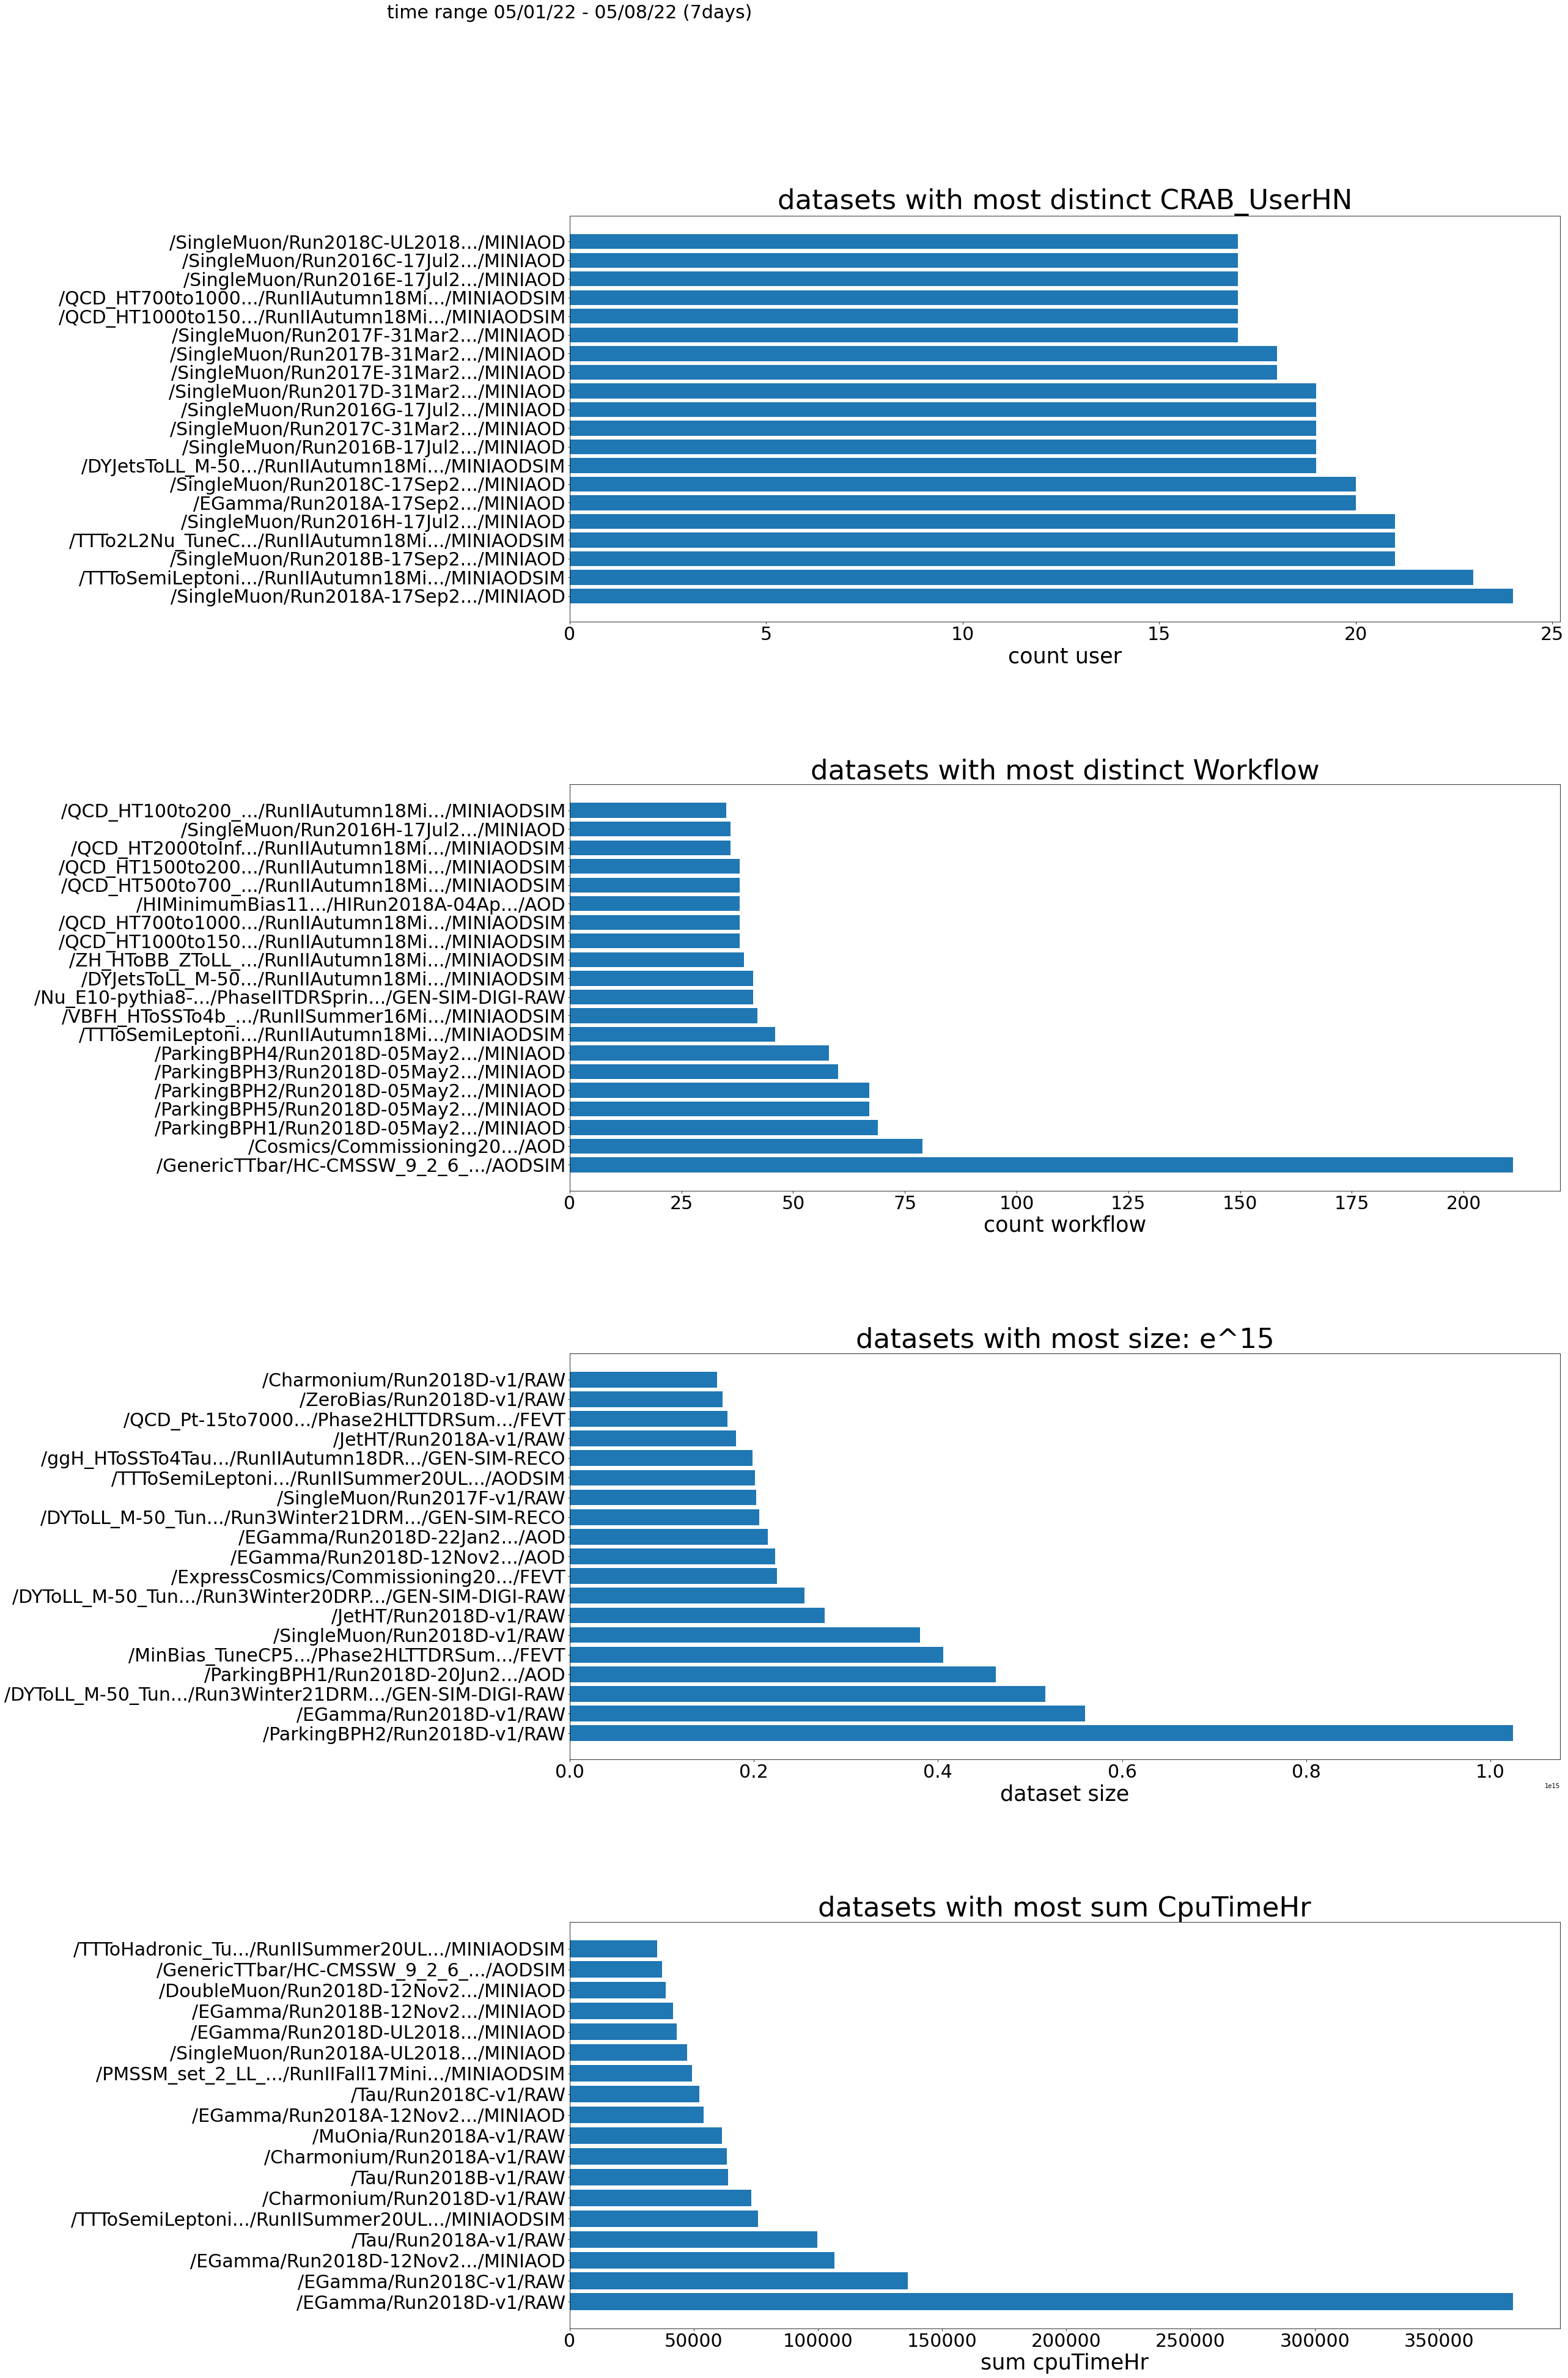

In [177]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 60))
fig.suptitle("time range 05/01/22 - 05/08/22 (7days)", fontsize=30)
ax[0].barh(short_datasetname(dataset_CRAB_UserHN["DESIRED_CMSDataset"]),list(dataset_CRAB_UserHN["distinct_CRAB_UserHN"]))
ax[0].set_title('datasets with most distinct CRAB_UserHN', fontsize=45)
ax[0].set_xlabel("count user", fontsize=35)
ax[0].tick_params("both", labelsize=30)

ax[1].barh(short_datasetname(dataset_Workflow["DESIRED_CMSDataset"]),list(dataset_Workflow["distinct_Workflow"]))
ax[1].set_title('datasets with most distinct Workflow', fontsize=45)
ax[1].set_xlabel("count workflow", fontsize=35)
ax[1].tick_params("both", labelsize=30)

ax[2].barh(short_datasetname(dataset_size["DESIRED_CMSDataset"]),list(dataset_size["sum_file_size"]))
ax[2].set_title('datasets with most size: e^15', fontsize=45)
ax[2].set_xlabel("dataset size", fontsize=35)
ax[2].tick_params("both", labelsize=30)

ax[3].barh(short_datasetname(dataset_sum_CpuTimeHr["DESIRED_CMSDataset"]),list(dataset_sum_CpuTimeHr["sum_CpuTimeHr"]))
ax[3].set_title('datasets with most sum CpuTimeHr', fontsize=45)
ax[3].set_xlabel("sum cpuTimeHr", fontsize=35)
ax[3].tick_params("both", labelsize=30)

plt.subplots_adjust(left=0.5,
                        bottom=0.1, 
                        right=2, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
plt.savefig("dataset-analysis.png", bbox_inches='tight')
plt.show()

### df4 - filter out HC datasets

In [168]:
df4 = df3.where(~ col('DESIRED_CMSDataset').like("%HC%"))

In [170]:
df4.show(40)

+--------------------+--------------------+-----------------+-------------------+-------------------+
|  DESIRED_CMSDataset|distinct_CRAB_UserHN|distinct_Workflow|      sum_file_size|      sum_CpuTimeHr|
+--------------------+--------------------+-----------------+-------------------+-------------------+
|/Cosmics/Commissi...|                   2|               79| 1.2902790558394E13|                0.0|
|/ParkingBPH1/Run2...|                   8|               69|1.28030382394928E14|                0.0|
|/ParkingBPH5/Run2...|                   8|               67|1.28647603163384E14|                0.0|
|/ParkingBPH2/Run2...|                   8|               67| 1.2872668679638E14|0.01972222222222222|
|/ParkingBPH3/Run2...|                   7|               60|1.28608136752911E14|                0.0|
|/ParkingBPH4/Run2...|                   4|               58|1.28451066970234E14|                0.0|
|/TTToSemiLeptonic...|                  23|               46|  5.446585250527E12| 

In [171]:
df4_pandas = df4.toPandas()

22/08/01 11:37:28 WARN TaskSetManager: Lost task 26.0 in stage 56.0 (TID 4501) (ithdp5007.cern.ch executor 75): FetchFailed(BlockManagerId(85, ithdp5007.cern.ch, 7337, None), shuffleId=14, mapIndex=53, mapId=53, reduceId=26, message=
org.apache.spark.shuffle.FetchFailedException: Block shuffle_14_53_26 is corrupted but the cause is unknown
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:1165)
	at org.apache.spark.storage.BufferReleasingInputStream.tryOrFetchFailedException(ShuffleBlockFetcherIterator.scala:1319)
	at org.apache.spark.storage.BufferReleasingInputStream.read(ShuffleBlockFetcherIterator.scala:1299)
	at java.io.BufferedInputStream.fill(BufferedInputStream.java:246)
	at java.io.BufferedInputStream.read1(BufferedInputStream.java:286)
	at java.io.BufferedInputStream.read(BufferedInputStream.java:345)
	at java.io.DataInputStream.read(DataInputStream.java:149)
	at org.sparkproject.guava.io.ByteStreams.read(Byte

In [172]:
dataset_CRAB_UserHN_4 = df4_pandas.sort_values(by=['distinct_CRAB_UserHN'], ascending=False).head(20)

In [173]:
dataset_Workflow_4 = df4_pandas.sort_values(by=['distinct_Workflow'], ascending=False).head(20)

In [174]:
dataset_size_4 = df4_pandas.sort_values(by=['sum_file_size'], ascending=False).head(20)

In [175]:
dataset_sum_CpuTimeHr_4 = df4_pandas.sort_values(by=['sum_CpuTimeHr'], ascending=False).head(20)

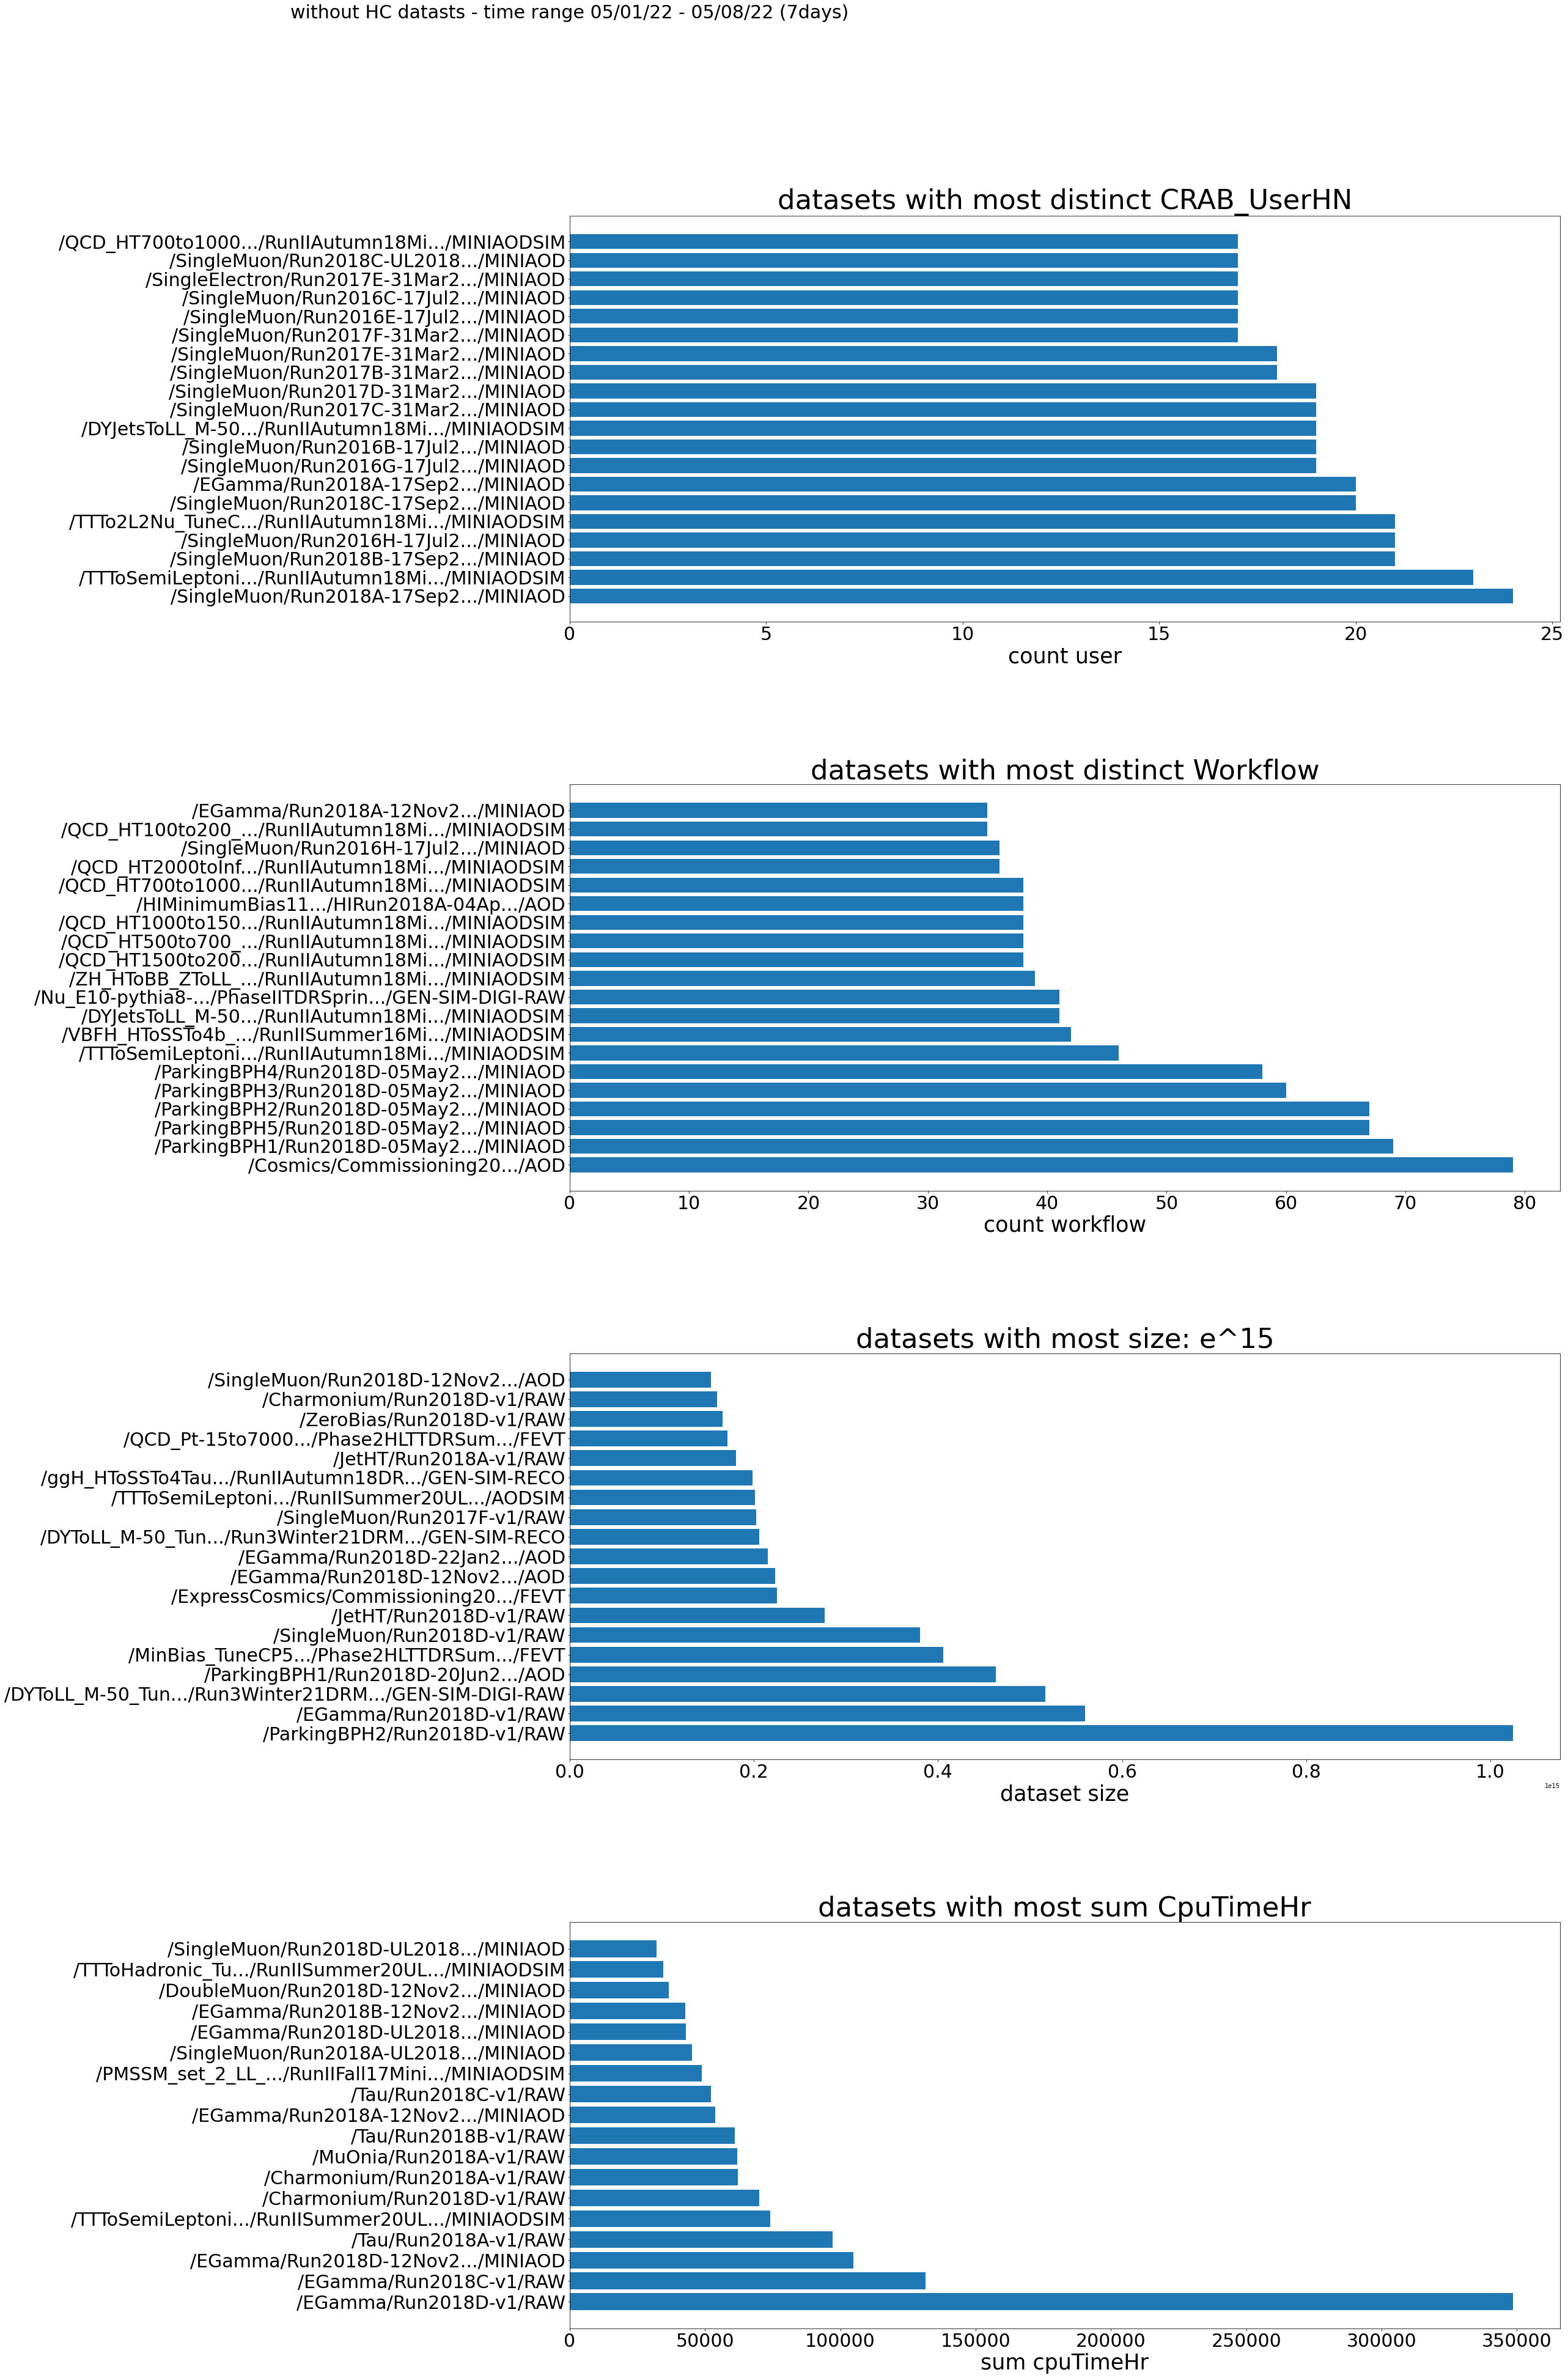

In [178]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 60))
fig.suptitle("without HC datasts - time range 05/01/22 - 05/08/22 (7days)", fontsize=30)
ax[0].barh(short_datasetname(dataset_CRAB_UserHN_4["DESIRED_CMSDataset"]),list(dataset_CRAB_UserHN_4["distinct_CRAB_UserHN"]))
ax[0].set_title('datasets with most distinct CRAB_UserHN', fontsize=45)
ax[0].set_xlabel("count user", fontsize=35)
ax[0].tick_params("both", labelsize=30)

ax[1].barh(short_datasetname(dataset_Workflow_4["DESIRED_CMSDataset"]),list(dataset_Workflow_4["distinct_Workflow"]))
ax[1].set_title('datasets with most distinct Workflow', fontsize=45)
ax[1].set_xlabel("count workflow", fontsize=35)
ax[1].tick_params("both", labelsize=30)

ax[2].barh(short_datasetname(dataset_size_4["DESIRED_CMSDataset"]),list(dataset_size_4["sum_file_size"]))
ax[2].set_title('datasets with most size: e^15', fontsize=45)
ax[2].set_xlabel("dataset size", fontsize=35)
ax[2].tick_params("both", labelsize=30)

ax[3].barh(short_datasetname(dataset_sum_CpuTimeHr_4["DESIRED_CMSDataset"]),list(dataset_sum_CpuTimeHr_4["sum_CpuTimeHr"]))
ax[3].set_title('datasets with most sum CpuTimeHr', fontsize=45)
ax[3].set_xlabel("sum cpuTimeHr", fontsize=35)
ax[3].tick_params("both", labelsize=30)

plt.subplots_adjust(left=0.5,
                        bottom=0.1, 
                        right=2, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
plt.savefig("dataset-analysis-without-HC.png", bbox_inches='tight')
plt.show()

full name of the top20 datasets with HC:

In [97]:
list(dataset_CRAB_UserHN["DESIRED_CMSDataset"])

['/SingleMuon/Run2018A-17Sep2018-v2/MINIAOD',
 '/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM',
 '/SingleMuon/Run2016H-17Jul2018-v1/MINIAOD',
 '/SingleMuon/Run2018B-17Sep2018-v1/MINIAOD',
 '/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM',
 '/SingleMuon/Run2018C-17Sep2018-v1/MINIAOD',
 '/EGamma/Run2018A-17Sep2018-v2/MINIAOD',
 '/SingleMuon/Run2016G-17Jul2018-v1/MINIAOD',
 '/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM',
 '/SingleMuon/Run2016B-17Jul2018_ver2-v1/MINIAOD',
 '/SingleMuon/Run2017C-31Mar2018-v1/MINIAOD',
 '/SingleMuon/Run2017D-31Mar2018-v1/MINIAOD',
 '/SingleMuon/Run2017E-31Mar2018-v1/MINIAOD',
 '/SingleMuon/Run2017B-31Mar2018-v1/MINIAOD',
 '/SingleMuon/Run2016C-17Jul2018-v1/MINIAOD',
 '/SingleMuon/Run2018C-UL2018_MiniAODv2-v2/MINIAOD',
 '/SingleElectron/Run2017E-31Mar2018-v1/MINIAO

In [98]:
list(dataset_Workflow["DESIRED_CMSDataset"])

['/GenericTTbar/HC-CMSSW_9_2_6_91X_mcRun1_realistic_v2-v2/AODSIM',
 '/Cosmics/Commissioning2021-PromptReco-v1/AOD',
 '/ParkingBPH1/Run2018D-05May2019promptD-v1/MINIAOD',
 '/ParkingBPH2/Run2018D-05May2019promptD-v1/MINIAOD',
 '/ParkingBPH5/Run2018D-05May2019promptD-v1/MINIAOD',
 '/ParkingBPH3/Run2018D-05May2019promptD-v1/MINIAOD',
 '/ParkingBPH4/Run2018D-05May2019promptD-v1/MINIAOD',
 '/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM',
 '/VBFH_HToSSTo4b_MH-125_TuneCUETP8M1_13TeV-powheg-pythia8/RunIISummer16MiniAODv3-PUMoriond17_rp_94X_mcRun2_asymptotic_v3-v2/MINIAODSIM',
 '/Nu_E10-pythia8-gun/PhaseIITDRSpring19DR-PU200_106X_upgrade2023_realistic_v3-v3/GEN-SIM-DIGI-RAW',
 '/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM',
 '/ZH_HToBB_ZToLL_M125_13TeV_powheg_pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v2/MINIAODSIM',
 '/HIMinimumBias11/HIRun2

In [99]:
list(dataset_size["DESIRED_CMSDataset"])

['/ParkingBPH2/Run2018D-v1/RAW',
 '/EGamma/Run2018D-v1/RAW',
 '/DYToLL_M-50_TuneCP5_14TeV-pythia8/Run3Winter21DRMiniAOD-FlatPU30to80FEVT_112X_mcRun3_2021_realistic_v16-v2/GEN-SIM-DIGI-RAW',
 '/ParkingBPH1/Run2018D-20Jun2021_UL2018-v1/AOD',
 '/MinBias_TuneCP5_14TeV-pythia8/Phase2HLTTDRSummer20ReRECOMiniAOD-PU200_withNewMB_111X_mcRun4_realistic_T15_v1_ext1-v2/FEVT',
 '/SingleMuon/Run2018D-v1/RAW',
 '/JetHT/Run2018D-v1/RAW',
 '/DYToLL_M-50_TuneCP5_14TeV-pythia8_HCAL/Run3Winter20DRPremixMiniAOD-110X_mcRun3_2021_realistic_v6-v1/GEN-SIM-DIGI-RAW',
 '/ExpressCosmics/Commissioning2022-Express-v1/FEVT',
 '/EGamma/Run2018D-12Nov2019_UL2018-v4/AOD',
 '/EGamma/Run2018D-22Jan2019-v2/AOD',
 '/DYToLL_M-50_TuneCP5_14TeV-pythia8/Run3Winter21DRMiniAOD-FlatPU30to80FEVT_112X_mcRun3_2021_realistic_v16-v2/GEN-SIM-RECO',
 '/SingleMuon/Run2017F-v1/RAW',
 '/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2/AODSIM',
 '/ggH_HToSSTo4Tau_MH-125_TuneCP5_13TeV

In [100]:
list(dataset_sum_CpuTimeHr["DESIRED_CMSDataset"])

['/EGamma/Run2018D-v1/RAW',
 '/EGamma/Run2018C-v1/RAW',
 '/EGamma/Run2018D-12Nov2019_UL2018-v4/MINIAOD',
 '/Tau/Run2018A-v1/RAW',
 '/Charmonium/Run2018D-v1/RAW',
 '/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2/MINIAODSIM',
 '/Tau/Run2018B-v1/RAW',
 '/MuOnia/Run2018A-v1/RAW',
 '/Charmonium/Run2018A-v1/RAW',
 '/Tau/Run2018C-v1/RAW',
 '/EGamma/Run2018A-12Nov2019_UL2018-v2/MINIAOD',
 '/PMSSM_set_2_LL_2_TuneCP2_13TeV-pythia8/RunIIFall17MiniAODv2-PUFall17Fast_GridpackScan_94X_mc2017_realistic_v15-v2/MINIAODSIM',
 '/SingleMuon/Run2018A-UL2018_MiniAODv2-v3/MINIAOD',
 '/EGamma/Run2018B-12Nov2019_UL2018-v2/MINIAOD',
 '/EGamma/Run2018D-UL2018_MiniAODv2-v2/MINIAOD',
 '/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL17MiniAOD-106X_mc2017_realistic_v6-v2/MINIAODSIM',
 '/GenericTTbar/HC-CMSSW_9_2_6_91X_mcRun1_realistic_v2-v2/AODSIM',
 '/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL16MiniAODAPV-106X_mcRun2